# Create ocean forcing for standalone CICE6

In [1]:
import xesmf as xe
from netCDF4 import Dataset
import argparse
import os
import numpy as np
from datetime import datetime
from dask.distributed import Client
import cosima_cookbook as cc
import re
from tqdm.notebook import tqdm

In [2]:
client = Client(threads_per_worker=1, memory_limit=0)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42501,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37015,Total threads: 1
Dashboard: /proxy/39261/status,Memory: 0 B
Nanny: tcp://127.0.0.1:35551,


In [6]:
def JRA55_regridder(grid_in, grid_out, method='bilinear', **kwargs): # based on https://nbviewer.jupyter.org/github/aekiss/ice_analysis/blob/main/ice_maps.ipynb
    '''Return a function that takes one dataarray argument on grid_in and returns that dataarray regridded onto grid_out.
    
    grid_in -- path to a JRA55-do NetCDF grid file
    grid_out -- path to a MOM grid file (U points are used)
    '''
    match = re.search(r'global\.(.*?)/', grid_out)
    if match:
        resolution = match.group(1)
        
    fn = f'{resolution}_U_grid_{method}.nc'
    weightfn = os.path.join("/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-10/atmosphere/JRA55-do/1-4-0/8XDAILY/regridders", fn)
    # print(weightfn)
    #'_'.join(['regrid', 'weights', os.path.splitext(os.path.basename(grid_in))[0],
               #          'to', os.path.splitext(os.path.basename(grid_out))[0], 'U', 'grid', method])+'.nc'
    ds_in = xr.open_dataset(grid_in).rename({'lat': 'y', 'lon': 'x'})

    ds_in = ds_in.isel(time=0).drop_vars(['time_bnds', 'lat_bnds'], errors='ignore')

    # Now drop the coordinate 'time' if it still exists
    if 'time' in ds_in.coords:
        ds_in = ds_in.drop_vars('time')
    
    # Finally, drop the 'bnds' dimension if it's no longer needed
    if 'bnds' in ds_in.dims:
        ds_in = ds_in.drop_dims('bnds')

    # ds_in
    #.drop_vars('prsn')
    #.rename({'ni': 'x', 'nj': 'y', 'tlon': 'lon', 'tlat': 'lat'})
    # try: # for /g/data/ik11/grids/ocean_grid_10.nc and /g/data/ik11/grids/ocean_grid_025.nc
    ds_out = xr.open_dataset(grid_out).rename({'ni': 'x', 'nj': 'y', 'tlon': 'lon', 'tlat': 'lat'})
    # except ValueError: # for /g/data/ik11/grids/ocean_grid_01.nc - see https://github.com/COSIMA/access-om2/issues/236
    #     ds_out = xr.open_dataset(grid_out).rename({'ni': 'x', 'nj': 'y', 'tlon': 'lon', 'tlat': 'lat'})
    #     # ds_out_fix = xr.open_dataset('/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output000/ocean/ocean-3d-u-1-monthly-mean-ym_1958_01.nc')\
    #                 # .rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
    #     ds_out = ds_out.assign_coords({'x': grid_out['x'], 'y': grid_out['y']})

    print(ds_in)
    print(ds_out)
    # make regridder
    rg = xe.Regridder(ds_in, ds_out, method=method, periodic = True, 
                      reuse_weights=False,#os.path.exists(weightfn), 
                      filename=weightfn, **kwargs)

    def outf(da): # define regridding function to output
        outds = rg(da)
        outds.coords['x'] = ds_out['x']
        outds.coords['y'] = ds_out['y']
        return outds.rename({'x': 'ni', 'y': 'nj', 'lon': 'LON', 'lat': 'LAT'})

    return outf




def load_cice_grid_with_degrees(
    input_path='/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc',
    # drop_vars=('ulat', 'ulon', 'htn', 'hte', 'angle', 'angleT', 'tarea', 'uarea'),
    chunks={'ny': -1, 'nx': -1}
):
    """
    Load a CICE grid file and convert lon/lat from radians to degrees.

    Parameters
    ----------
    input_path : str
        Path to the input CICE grid file.
    chunks : dict
        Dask chunk sizes.

    Returns
    -------
    xr.Dataset
        Modified dataset with lon/lat in degrees.
    """
    ds = xr.open_dataset(input_path, chunks=chunks)
    
    lon_rad = ds.tlon
    lat_rad = ds.tlat
    
    ds['tlon'] = np.rad2deg(lon_rad)
    ds['tlat'] = np.rad2deg(lat_rad)

    ds = ds.rename({'ni': 'x', 'nj': 'y', 'tlon': 'lon', 'tlat': 'lat'})
    
    return ds


def halo_extrapolate(a,ew_bndy_type,ns_bndy_type):
    '''
    Extrapolate to 'halo' cell as in CICE code
    ice_boundary.F90:ice_HaloExtrapolate.
    inputs:
    a: array nx+1, ny+1 (nghost/nhalo hard-coded as 1 for now)
    ew_bndy_type: east/west boundary type (cyclic, regional, etc)
    ns_bndy_type: norh/south boundary type (cyclic, regional, etc)

    return: a with halo applied
    '''

    # get dimension of a
    # expected to be 0:nx+nghost, 0:ny+nghost
    nj, ni = a.shape # note with Python NetCDF is nj, ni order
    # W/E edges
    if ew_bndy_type == 'cyclic':
        a[: ,0] = a[:,-2] # -2, since -1 is ghost cell
        a[:,-1] = a[:, 1] #  1, since  0 is ghost cell
    else: # if (trim(ew_bndy_type) /= 'cyclic') then
        a[:, 0] = 2.0*a[:, 1] - a[:, 2]
        a[:,-1] = 2.0*a[:,-2] - a[:,-3]

    # south edge
    if ns_bndy_type == 'cyclic':
        a[0,:] = a[-2,:] # -2, since -1 is ghost cell
    else:
        a[0,:] = 2.0*a[1,:] - a[2,:]

    # north edge treated a little different, depending
    # on if bndy type is tripole
    if ns_bndy_type == 'cyclic':
        a[-1,:] = a[1,:] # 1, since 0 is ghost cell

    elif (ns_bndy_type != 'cyclic'  and
          ns_bndy_type != 'tripole' and
          ns_bndy_type != 'tripoleT'):

        a[-1,:] = 2.0*a[-2,:] - a[-3,:]

    else:
        pass # do nothing

    # return array with halo upated
    return a


def Tlatlon(ulat,ulon,ew_bndy_type,ns_bndy_type):
    '''
    Make TLAT/TLON from ULAT/ULON.
    see ice_grid.F90:Tlatlon for method
    Inputs:
    ulat: U grid latitude in degrees
    ulon: U grid longitude in degrees

    output:
    tlat in degrees
    tlon in degrees
    '''

    # method obtained from ice_grid.F90: subroutine Tlatlon
    ulatcos = np.cos(np.deg2rad(ulat))
    ulatsin = np.sin(np.deg2rad(ulat))

    uloncos = np.cos(np.deg2rad(ulon))
    ulonsin = np.sin(np.deg2rad(ulon))

    # initialize array with nghost=1 on each side
    nj, ni = ulatcos.shape # note: Python NetCDF is nj, ni order
    print("Tlatlon nj, ni", nj, ni)

    nghost     = 1
    workdims   = (nj+2*nghost,ni+2*nghost)
    #print("Tlatlon workdims", workdims)

    ulatcos1 = np.zeros(workdims,dtype='f8')
    ulatsin1 = np.zeros(workdims,dtype='f8')
    uloncos1 = np.zeros(workdims,dtype='f8')
    ulonsin1 = np.zeros(workdims,dtype='f8')

    # fill middle of work arrays
    ulatcos1[1:nj+1,1:ni+1] = ulatcos
    ulatsin1[1:nj+1,1:ni+1] = ulatsin

    # fill middle of work arrays
    ulatcos1[1:nj+1,1:ni+1] = ulatcos
    ulatsin1[1:nj+1,1:ni+1] = ulatsin

    uloncos1[1:nj+1,1:ni+1] = uloncos
    ulonsin1[1:nj+1,1:ni+1] = ulonsin

    # fill halos
    ulatcos1 = halo_extrapolate(ulatcos1,ew_bndy_type,ns_bndy_type)
    ulatsin1 = halo_extrapolate(ulatsin1,ew_bndy_type,ns_bndy_type)
    uloncos1 = halo_extrapolate(uloncos1,ew_bndy_type,ns_bndy_type)
    ulonsin1 = halo_extrapolate(ulonsin1,ew_bndy_type,ns_bndy_type)

    # now do computations as in ice_grid.F90:Tlatlon

    # x, y, z are full 2d
    x = uloncos1 * ulatcos1
    y = ulonsin1 * ulatcos1
    z = ulatsin1

    tx = 0.25*(x[0:nj,  0:ni  ]   + # x1
               x[0:nj,  1:ni+1]   + # x2
               x[1:nj+1,0:ni  ]   + # x3
               x[1:nj+1,1:ni+1])    # x4

    #print("Tlonlat: x.shape", x.shape)
    #print("Tlonlat: tx.shape", tx.shape)


    ty = 0.25*(y[0:nj,  0:ni  ]   + # y1
               y[0:nj,  1:ni+1]   + # y2
               y[1:nj+1,0:ni  ]   + # y3
               y[1:nj+1,1:ni+1])    # y4


    tz = 0.25*(z[0:nj,  0:ni  ]   + # z1
               z[0:nj,  1:ni+1]   + # z2
               z[1:nj+1,0:ni  ]   + # z3
               z[1:nj+1,1:ni+1])    # z4

    da = np.sqrt(tx*tx + ty*ty + tz*tz)

    tz = tz/da

    tlon = np.arctan2(ty,tx)
    tlat = np.arcsin(tz)

    # returnd tlat, tlon in degrees
    return np.rad2deg(tlat), np.rad2deg(tlon)

def make_regridder(lon1, lat1, lon2, lat2, method, periodic, blin_grid_name,
                   lon1_b=None, lat1_b=None, lon2_b=None, lat2_b=None):
    '''
    make nearest neighbor xESMF regridder object.
    input:
    lon1: source longitudes (degrees)
    lat1: source latitudes  (degrees)
    lon2: target longitudes (degrees)
    lat2: target latitudes (degrees)
    method: regridding  method (bilinear, patch, conservative, nearest_s2d)
    periodic: True if periodic longitudes, false if not
    grdname: filename for regridder (Ugrid or Tgrid)
    '''
    if method != "conservative":
        # define grids for regridder
        grid1 = {'lon' : lon1, 'lat' : lat1}
        grid2 = {'lon' : lon2, 'lat' : lat2}


    else:
        # conservative needs boundary lon/lat
        grid1 = {'lon'   : lon1,   'lat'   : lat1,
                 'lon_b' : lon1_b, 'lat_b' : lat1_b}

        grid2 = {'lon'   : lon2,   'lat'   : lat2,
                 'lon_b' : lon2_b, 'lat_b' : lat2_b}

    # make regridder
    # here specify reuse_weights=False to re-generate weight file.
    # if wanted to reuse file inteas of making int, 
    # check if file exists and change use_file_weights=True. 
    # see commented out example below 
    use_file_weights=False

    # check if regrid file exists.
    # If so, reuse file instead of regenerating.
    if (os.path.isfile(blin_grid_name)):
        print("Reusing regridder")
        use_file_weights = True
        

    regridder = xe.Regridder(ds_in=grid1,ds_out=grid2,
                             method=method,
                             periodic=periodic,
                             filename=blin_grid_name,
                             reuse_weights=use_file_weights)


    return regridder

def init_ncout(ncout,nc1,llat,llon):

    '''
    Initialize output NetCDF file
    with proper units and dimensions.
    '''

    dsout = Dataset(ncout,'w',format='NETCDF4_CLASSIC')
    # print(dsout)

    # get dimensions from size of lat
    (nlat,nlon) = llat.shape

    # create dimensions
    time  = dsout.createDimension('time',None) # unlimited
    dim_j = dsout.createDimension('nj',nlat)
    dim_i = dsout.createDimension('ni',nlon)

    # copy time variable directly from grid1_ds
    source_time = nc1['time']
    
    # create time dimension and variable in dsout
    # time = dsout.createDimension('time', None)  # unlimited
    times = dsout.createVariable('time', 'f8', ('time',))
    
    # copy attributes
    for attr in source_time.ncattrs():
        setattr(times, attr, getattr(source_time, attr))
    
    # copy values
    times[:] = source_time[:]

    # create LON/LAT variables
    LON = dsout.createVariable('LON','f8',('nj','ni',))
    LON.units = 'degrees_east'

    LAT = dsout.createVariable('LAT','f8',('nj','ni',))
    LAT.units = 'degrees_north'

    # write LON, LAT to file
    LON[:] = llon[:,:]
    LAT[:] = llat[:,:]
    

    return dsout

## Define parameters

In [31]:
YEAR = 1960
RESOLUTION = "025" # "10" or "025"


target_dir = "/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-"+ RESOLUTION + "/ocean"
if RESOLUTION == "10":
    ocn_dir = "/g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle6"
    target_grid_fn = "/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc"
elif RESOLUTION == "025":
    ocn_dir = "/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6"
    target_grid_fn = "/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.025deg/2024.05.14/grid.nc"
    
ds_grid = xr.open_dataset(target_grid_fn)
os.makedirs(target_dir, exist_ok=True)

ncout = "/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-" + RESOLUTION + f"/ocean/ACCESS-OM2/ocean_surface_{YEAR}.nc" # Output file name (NetCDF)

ocn_vars = ["sst", "sss"]

In [32]:
def regrid_ocean_surface(src_file, target_grid_fn, ncout):
    ds_ocn = Dataset(src_file,'r',format='NETCDF3_64BIT_OFFSET')
    lon1     = ds_ocn['xt_ocean'][:]  # 1D
    lat1     = ds_ocn['yt_ocean'][:]  # 1D
    
    ds_grid = Dataset(target_grid_fn,'r',format='NETCDF4')
    ulon2    = ds_grid["ulon"][:,:] # 2D. Assumed ULON in degrees
    ulat2    = ds_grid["ulat"][:,:] # 2D. Assumed ULAT in degrees
    if np.max(np.abs(ulat2)) < 10. :
       ulon2 = np.rad2deg(ulon2)
       ulat2 = np.rad2deg(ulat2)
    
    # make tgrid from ugrid
    ew_bndy_type = 'cyclic'
    ns_bndy_type = 'open'
    tlat2, tlon2 = Tlatlon(ulat2,ulon2,ew_bndy_type,ns_bndy_type)
    
    
     # make regridders 
    method = 'bilinear'
    periodic = True
    blin_grid_name = "/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-" + RESOLUTION + "/ocean/ACCESS-OM2/regridders/bilinear_mom5_" + RESOLUTION + "deg.nc"
    rgrd_bilinear = make_regridder(lon1,lat1,tlon2,tlat2,
                                   method,periodic,blin_grid_name)
    
    dsout = init_ncout(ncout,ds_ocn,tlat2,tlon2)
    
    # no longer need grid1, grid2
    ds_ocn.close()
    # ds_grid.close()
    
    ds_ocn = xr.open_dataset(src_file)
    for var in ocn_vars:
    
        # fname = os.path.join(f"{jra55pathdict[var]:s}", f"{jra55dict[var]:s}{jra55DTGdict[var]:s}.nc")
        # print("Reading ", fname)
        # jra_ds = Dataset(fname,'r',format='NETCDF4_CLASSIC')
        # jra_ds = xr.open_dataset(fname)
        # do interpolation
        print("Interpolating ", var)
        data_interp = rgrd_bilinear(ds_ocn[var][:,:,:])  # xarray.DataArray
    
        # create output variable in NetCDF file
        outvar = dsout.createVariable(var, 'f4', ('time','nj','ni'))
    
        # write data
        outvar[:] = data_interp.values
    
        # set NetCDF variable attributes
        outvar.setncattr('coordinates', "time tlat tlon")
        outvar.setncattr('long_name', ds_ocn[var].attrs.get('long_name', ''))
        outvar.setncattr('units', ds_ocn[var].attrs.get('units', ''))

    tlat_var = dsout.createVariable('TLAT', 'f4', ('nj', 'ni'))
    tlat_var.units = 'degrees_north'
    tlat_var.long_name = 'T-grid latitude'
    tlat_var[:] = tlat2
    
    tlon_var = dsout.createVariable('TLON', 'f4', ('nj', 'ni'))
    tlon_var.units = 'degrees_east'
    tlon_var.long_name = 'T-grid longitude'
    tlon_var[:] = tlon2
    
    
    # Write and close to output file
    dsout.close()
    print("Done")

# TEST
YEAR = 1960
src_file = os.path.join(ocn_dir, f"output307/ocean/ocean_month.nc")
regrid_ocean_surface(src_file, target_grid_fn, ncout)

Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done


In [33]:
# blin_grid_name = "/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-" + RESOLUTION + "/ocean/ACCESS-OM2/regridders/bilinear_mom5_" + RESOLUTION + "deg.nc"

In [34]:
# blin_grid_name = "/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-" + RESOLUTION + "/ocean/ACCESS-OM2/regridders/bilinear_mom5_" + RESOLUTION + "deg.nc"
# blin_grid_name

In [35]:
# target_grid_fnx

In [36]:
for counter, year in tqdm(zip(range(305, 366), range(1958, 2019)), total=61):
    src_file = os.path.join(ocn_dir, f"output{counter}/ocean/ocean_month.nc")
    print(f"Processing {src_file}")
    ncout = "/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-"+RESOLUTION+f"/ocean/ACCESS-OM2/ocean_surface_{year}.nc" # Output file name (NetCDF)
    # ds_ocn = xr.open_dataset(src_file)
    regrid_ocean_surface(src_file, target_grid_fn, ncout)
print("All done.")

  0%|          | 0/61 [00:00<?, ?it/s]

Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output306/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output307/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output308/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output309/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output310/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output311/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output312/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output313/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output314/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output315/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output316/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output317/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output318/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output319/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output320/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output321/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output322/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output323/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output324/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output325/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output326/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output327/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output328/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output329/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output330/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output331/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output332/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output333/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output334/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output335/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output336/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output337/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output338/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output339/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output340/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output341/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output342/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output343/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output344/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output345/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output346/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output347/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output348/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output349/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output350/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output351/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output352/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output353/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output354/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output355/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output356/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output357/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output358/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output359/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output360/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output361/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output362/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output363/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output364/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
Processing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output365/ocean/ocean_month.nc
Tlatlon nj, ni 1080 1440
Reusing regridder


  warnings.warn(



Interpolating  sst


  warnings.warn(



Interpolating  sss
Done
All done.


## Check that the interpolation looks correct

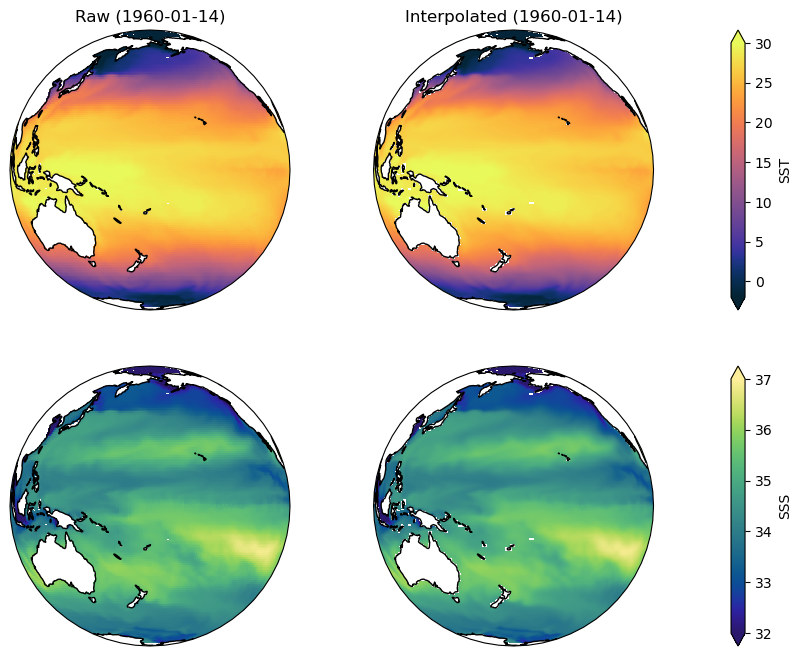

In [15]:
year_idx = 2
count_range = range(305, 366)
year_range = range(1958, 2019)

counter = count_range[year_idx]
year = year_range[year_idx]
ds_ocn_raw = xr.open_dataset(os.path.join(ocn_dir, f"output{counter}/ocean/ocean_month.nc"))
ds_ocn_interp = xr.open_dataset("/g/data/ps29/nd0349/input/CICE_data/forcing/access-om3-"+RESOLUTION+f"/ocean/ACCESS-OM2/ocean_surface_{year}.nc")

time_index = 0

variables = ['sst', 'sss']

fig, axes = plt.subplots(2, 2, figsize=(10, 8),
                         subplot_kw={'projection': ccrs.Orthographic(180, 0)})

cmap_dict = {'sst': cmo.thermal,'sss': cmo.haline}
vrange_dict = {'sst': (-2, 30), 'sss': (32, 37)}

for i, var in enumerate(variables):
    # Select raw and interpolated data for the variable
    
    data_raw = ds_ocn_raw[var].isel(time=time_index)
    data_interp = ds_ocn_interp[var].isel(time=time_index)

    if var == "sst":
        data_raw = data_raw -273.15
        data_interp = data_interp -273.15
    
    # Get lon/lat for interpolated data (only needed once but fine here)
    lon = ds_ocn_interp['TLON'].values
    lat = ds_ocn_interp['TLAT'].values
    
    # Determine color scale limits
    # vmin = min(data_raw.min().item(), data_interp.min().item())
    # vmax = max(data_raw.max().item(), data_interp.max().item())
    
    # Plot raw data (left column)
    pcm_raw = data_raw.plot(ax=axes[i, 0], transform=ccrs.PlateCarree(),
                            vmin=vrange_dict[var][0], vmax=vrange_dict[var][1], cmap=cmap_dict[var], add_colorbar=False)
    axes[i, 0].coastlines()
    axes[0, 0].set_title(f"Raw ({pd.to_datetime(data_raw.time.values).strftime('%Y-%m-%d')})")
    axes[1, 0].set_title(f"")
    
    # Plot interpolated data (right column)
    pcm_interp = axes[i, 1].pcolormesh(lon, lat, data_interp.values, transform=ccrs.PlateCarree(),
                                      shading='auto', cmap=cmap_dict[var], vmin=vrange_dict[var][0], vmax=vrange_dict[var][1])
    axes[i, 1].coastlines()
    axes[0, 1].set_title(f"Interpolated ({pd.to_datetime(data_interp.time.values).strftime('%Y-%m-%d')})")
    
    # Add colorbar for each row spanning both column
    fig.colorbar(pcm_interp, ax=axes[i, :], orientation='vertical', fraction=0.04, pad=0.1, label=var.upper(), extend='both')

# plt.tight_layout()
plt.show()

In [16]:
data_interp

<xarray.DataArray 'sss' (nj: 1080, ni: 1440)> Size: 6MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 1960-01-14T12:00:00
Dimensions without coordinates: nj, ni
Attributes:
    long_name:  Practical Salinity
    units:      psu

In [181]:
data_interp.time.values

numpy.datetime64('2018-01-14T12:00:00.000000000')

In [183]:
# time_val = 
time_str = pd.to_datetime(data_interp.time.values).strftime('%Y-%m-%d')
time_str

'2018-01-14'

## Compare the gridlines

In [43]:
import numpy as np

# Extract 1D coordinate arrays
x = ds_ocn['xt_ocean'].values
y = ds_ocn['yt_ocean'].values

# Create meshgrid (note the order: y first, then x for 2D grid alignment)
lon, lat = np.meshgrid(x, y)  # X and Y will have shape (len(y), len(x))


In [25]:
lon#.plot()

array([[-279.5, -278.5, -277.5, ...,   77.5,   78.5,   79.5],
       [-279.5, -278.5, -277.5, ...,   77.5,   78.5,   79.5],
       [-279.5, -278.5, -277.5, ...,   77.5,   78.5,   79.5],
       ...,
       [-279.5, -278.5, -277.5, ...,   77.5,   78.5,   79.5],
       [-279.5, -278.5, -277.5, ...,   77.5,   78.5,   79.5],
       [-279.5, -278.5, -277.5, ...,   77.5,   78.5,   79.5]])

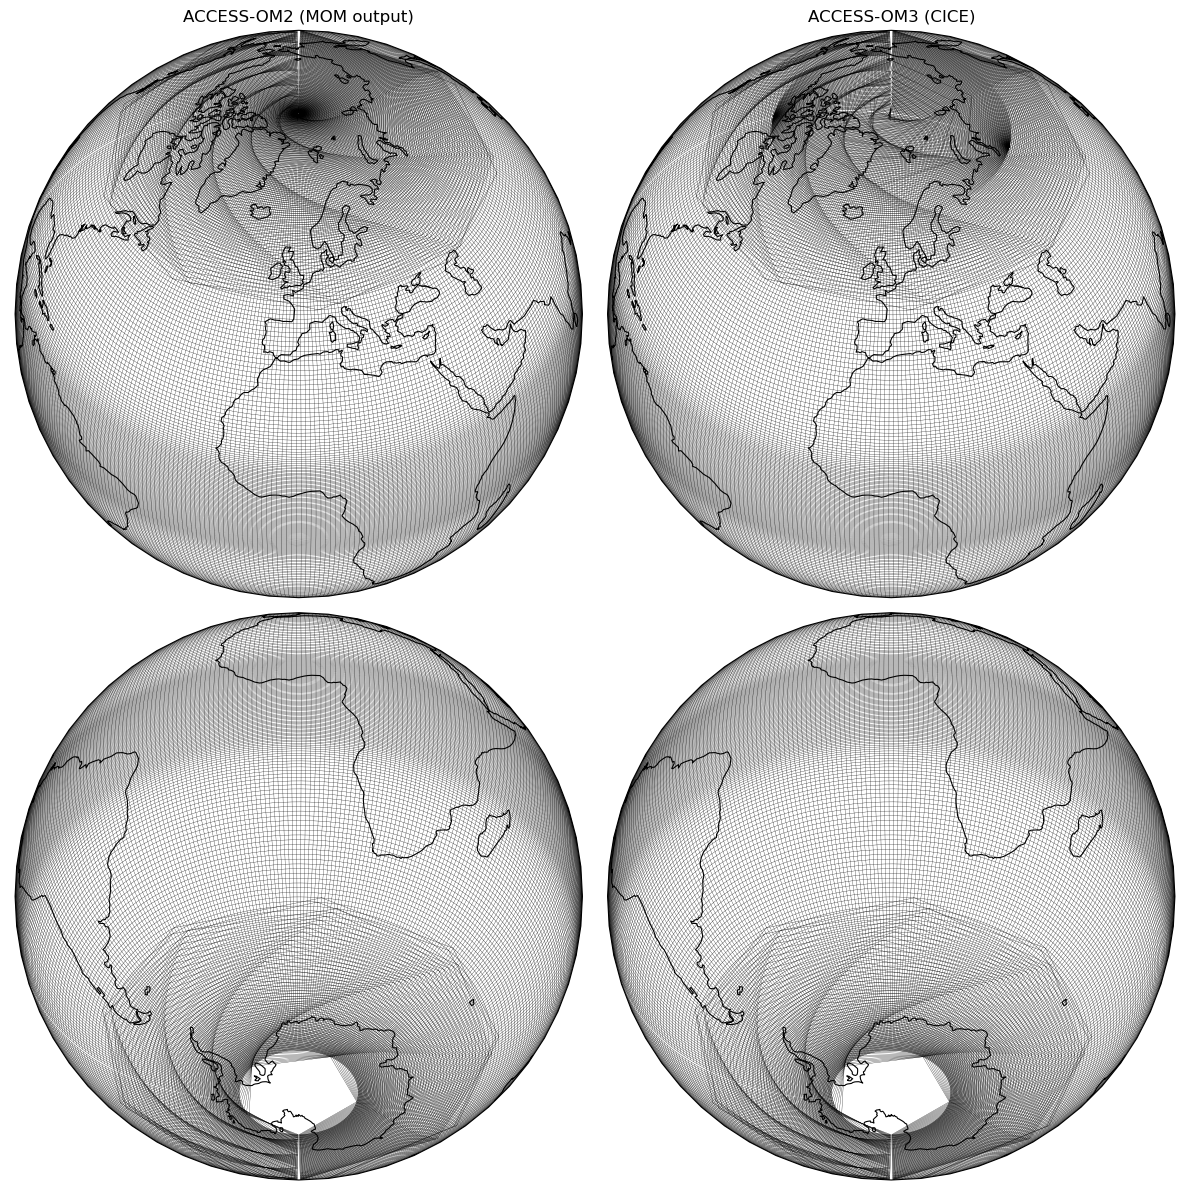

In [58]:
# Assume two datasets with 'tlon' and 'tlat' in radians
lon1 = lon
lat1 = lat

lon2 = np.rad2deg(ds_grid['tlon'])
lat2 = np.rad2deg(ds_grid['tlat'])

# Wrap both longitude arrays into [-180, 180]
lon1_wrapped = (lon1 + 360) % 360 - 180
lon2_wrapped = (lon2 + 360) % 360 - 180

# Define projections for each subplot
proj_top = ccrs.Orthographic(0, 45)
proj_bottom = ccrs.Orthographic(0, -45)

# Create subplots with specified projections
fig, axes = plt.subplots(2, 2, figsize=(12, 12), 
                         subplot_kw={'projection': ccrs.PlateCarree()})  # temporary
for ax in axes.flat:
    ax.set_frame_on(False)           # Hides the axes frame
    ax.axis('off')   
# Now manually set the projection for each axis
axes[0, 0] = plt.subplot(2, 2, 1, projection=proj_top)
axes[0, 1] = plt.subplot(2, 2, 2, projection=proj_top)
axes[1, 0] = plt.subplot(2, 2, 3, projection=proj_bottom)
axes[1, 1] = plt.subplot(2, 2, 4, projection=proj_bottom)

# === First subplot (Top left - Grid 1) ===
ax1 = axes[0, 0]
ax1.set_global()
ax1.coastlines(resolution='110m', linewidth=0.8)
ax1.set_title("ACCESS-OM2 (MOM output)")

for j in range(lat1.shape[0]):
    ax1.plot(lon1_wrapped[j, :], lat1[j, :], color='black', linewidth=0.2,
             transform=ccrs.PlateCarree())
for i in range(lon1.shape[1]):
    ax1.plot(lon1_wrapped[:, i], lat1[:, i], color='black', linewidth=0.2,
             transform=ccrs.PlateCarree())

# === Second subplot (Top right - Grid 2) ===
ax2 = axes[0, 1]
ax2.set_global()
ax2.coastlines(resolution='110m', linewidth=0.8)
ax2.set_title("ACCESS-OM3 (CICE)")

for j in range(lat2.shape[0]):
    ax2.plot(lon2_wrapped[j, :], lat2[j, :], color='black', linewidth=0.2,
             transform=ccrs.PlateCarree())
for i in range(lon2.shape[1]):
    ax2.plot(lon2_wrapped[:, i], lat2[:, i], color='black', linewidth=0.2,
             transform=ccrs.PlateCarree())


# === Third subplot (Bottom left - Grid 1) ===
ax3 = axes[1, 0]
ax3.set_global()
ax3.coastlines(resolution='110m', linewidth=0.8)

for j in range(lat1.shape[0]):
    ax3.plot(lon1_wrapped[j, :], lat1[j, :], color='black', linewidth=0.2,
             transform=ccrs.PlateCarree())
for i in range(lon1.shape[1]):
    ax3.plot(lon1_wrapped[:, i], lat1[:, i], color='black', linewidth=0.2,
             transform=ccrs.PlateCarree())


# === Fourth subplot (Bottom right - Grid 2) ===
ax4 = axes[1, 1]
ax4.set_global()
ax4.coastlines(resolution='110m', linewidth=0.8)

for j in range(lat1.shape[0]):
    ax4.plot(lon2_wrapped[j, :], lat1[j, :], color='black', linewidth=0.2,
             transform=ccrs.PlateCarree())
for i in range(lon1.shape[1]):
    ax4.plot(lon2_wrapped[:, i], lat1[:, i], color='black', linewidth=0.2,
             transform=ccrs.PlateCarree())


plt.tight_layout()
plt.show()

In [47]:
# lon = np.rad2deg(ds_grid['tlon'])
# lat = np.rad2deg(ds_grid['tlat'])

# lon_wrapped = (lon + 360) % 360 - 180

# fig = plt.figure(figsize=(12, 6))
# ax = plt.axes(projection=ccrs.Orthographic(0, 0))
# ax.set_global()
# ax.coastlines(resolution='110m', linewidth=0.8)
# ax.gridlines(draw_labels=True)

# # Plot lines of constant latitude (horizontal lines)
# for j in range(lat.shape[0]):
#     ax.plot(lon_wrapped[j, :], lat[j, :], color='black', linewidth=0.1, transform=ccrs.PlateCarree())

# # Plot lines of constant longitude (vertical lines)
# for i in range(lon.shape[1]):
#     ax.plot(lon_wrapped[:, i], lat[:, i], color='black', linewidth=0.1, transform=ccrs.PlateCarree())

# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
# ax.grid(True)
# plt.show()

In [41]:
# ds_in = xr.open_dataset(src_file)
# ds_in

# ds_grid

In [42]:
# xr.open_dataset('/g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle6/output365/ocean/ocean_month.nc')

In [ ]:
weightfn = '_'.join(['regrid', 'weights', os.path.splitext(os.path.basename(grid_in))[0],
                         'to', os.path.splitext(os.path.basename(grid_out))[0], 'U', 'grid', method])+'.nc'
    ds_in = xr.open_dataset(grid_in)
    try: # for /g/data/ik11/grids/ocean_grid_10.nc and /g/data/ik11/grids/ocean_grid_025.nc
        ds_out = xr.open_dataset(grid_out).rename({'xu_ocean': 'x', 'yu_ocean': 'y', 'geolon_c': 'lon', 'geolat_c': 'lat'})
    except ValueError: # for /g/data/ik11/grids/ocean_grid_01.nc - see https://github.com/COSIMA/access-om2/issues/236
        ds_out = xr.open_dataset(grid_out).rename({'grid_x_C': 'x', 'grid_y_C': 'y', 'geolon_c': 'lon', 'geolat_c': 'lat'})
        ds_out_fix = xr.open_dataset('/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output000/ocean/ocean-3d-u-1-monthly-mean-ym_1958_01.nc')\
                    .rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
        ds_out = ds_out.assign_coords({'x': ds_out_fix['x'], 'y': ds_out_fix['y']})

    # make regridder
    rg = xesmf.Regridder(ds_in, ds_out, method=method, reuse_weights=os.path.exists(weightfn), filename=weightfn, **kwargs)

    def outf(da): # define regridding function to output
        outds = rg(da)
        outds.coords['x'] = ds_out['x']
        outds.coords['y'] = ds_out['y']
        return outds.rename({'x': 'xu_ocean', 'y': 'yu_ocean', 'lon': 'longitude', 'lat': 'latitude'})